In [145]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, patches
import matplotlib
from scipy.signal import argrelextrema, resample
from scipy.stats import describe
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Ignore some warnings.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set graphing params.
sns.set()
matplotlib.rcParams['figure.figsize'] = (25.0, 10.0)

### Munging functions
These are helper functions. Columns are renamed to a standard format:

Header | Value    
   --- | --- 
f | Raw force (N)
mdia | Muscle diameter (in)
msgtype | N/A
pwm | Digital PWM value
rc | Constant
rw | Constant
t  | Temperature
t0 | Starting temperature
timestamp | Absolute time (s)

In [6]:
# Renames columns to standard format listed above,
# Normalizes timestamps relative to 0 (instead of experiment start time),
# Fills NaNs, inverts force.
def clean(df):
    df.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
    if(df.iloc[0].timestamp > 0):
        df.timestamp -= df.iloc[0].timestamp
    df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)
    df.f = -df.f
    return df.fillna(0)

In [7]:
# Grabs rolling average with default lag of 300-points.
# You can set #points in rolling window with `window` param, and
# select whether to add the rolling average column to the given 
# dataframe with `add_col` param.
def ma(df, window=500, add_col=True):
    m = df.f.rolling(window=window).mean()
    if add_col:
        df['f_ra'] = m
        return df.fillna(0)
    return m

In [8]:
# Grabs minima and maxima.
# This is its own function only because this is an expensive operation.
# Note this function operates on the rolling average, not the raw force, to prevent noisy points from interfering.
def get_extrema(df, order=2000, ra=False):
    col = 'f_ra' if ra else 'f'
    maxima = argrelextrema(df[col].values, np.greater, order=order)
    minima = argrelextrema(df[col].values, np.less, order=order)
    return minima, maxima

In [9]:
# Labels cycles based on local (force) minima and maxima.
# Points not belonging to a valid cycle, e.g. at start and end of experiment,
# are labeled with <cycle# = -1>.
def label_cycles(df, minima, maxima, abs_min=None, abs_max=None, plot_boxes=True):
    # Plot line connecting all minima, and another line connecting all maxima.
    fig, ax = plt.subplots(figsize=(25, 6), nrows=1, ncols=1)
    if abs_min and abs_max:
        ax.plot(df.f, alpha=0.3)
        ax.plot(df.f.iloc[abs_max[0].tolist()])
        ax.plot(df.f.iloc[abs_min[0].tolist()])

    # Label cycles.
    df['cycle'] = -1
    for i in range(minima[0].size-1):
        rng = list(range(minima[0][i], minima[0][i+1]))
        df.iloc[rng, df.columns.get_loc('cycle')] = i # I don't know why `iloc` succeeds while `loc` fails here. I spent 1.5 hours on this bug.
  
    # Draw bounding boxes around each cycle.
    if plot_boxes:
        for i in minima[0].tolist():
            ax.add_patch(
                patches.Rectangle((i, df.f.min()), df[df.cycle==i].shape[0], df.f.max()-df.f.min(), linewidth=1, edgecolor='black', facecolor='none', alpha=0.2, linestyle=':')
            )
    return df

In [150]:
# Squashes periods down to a constant for all rows in a dataset.
# You can set the desired period with param `period`.
# If you don't, the function just chooses the shortest period.
def squash_periods(df, period=-1, plot_cycles=True):
    cycles, c_to_p = [], {} # maps cycles to their periods
    fig, ax = plt.subplots(figsize=(25, 12), nrows=1, ncols=1)
    for c in range(df.cycle.max()):
        c_to_p[c] = df[df.cycle==c].shape[0]
    if period<0:
        period = int(min(c_to_p.values()))
    for c in range(df.cycle.max()):
        c_resampled = resample(df[df.cycle==c], period)
        cycles.append(pd.DataFrame(c_resampled))
        if plot_cycles:
            ax.plot(pd.DataFrame(c_resampled)[9], color=plt.cm.RdYlBu(c/df.cycle.max()))
    X = pd.concat(cycles).reset_index(drop=True)
    X.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp", "f_ra", "cycle"]
    X.timestamp = df.timestamp.iloc[:X.timestamp.size,]
    if plot_cycles:
        cmap = plt.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=0, vmax=df.cycle.max()),
            cmap=plt.get_cmap('RdYlBu', df.cycle.max())
        )
        cmap.set_array([])
        plt.colorbar(cmap, orientation="horizontal", pad=0.1)
    return X, c_to_p

In [11]:
# Prints descriptive stats about a 1-D dataset.
# (Mean, stdev, first quartiles, and index of dispersion if `dispersion=True`).
def stats(series, dispersion=True):
    print("SUMMARY\n")
    if dispersion:
        mean, var = np.mean(series.values), np.var(series.values)
        print("index of dispersion\t%f\n%s" % (var/mean, '-'*50))
    print(series.describe(include='all'))

In [35]:
# Takes difference of each point by given lag (default=1 cycle, not 1 pt).
def difference(df, periods=None, cols_to_diff=['f', 't', 'f_ra']):
    if not periods:
        periods = df[df.cycle==1].size
    return df[cols_to_diff].diff(periods=periods).fillna(0)

In [116]:
# Inverts a differenced observation.
def undifference(df, differences, periods=None):
    # TODO
    pass

In [ ]:
def reg_detrend(series):
    reg, poly = LinearRegression(), PolynomialFeatures(2)
    X_t = poly.fit_transform()

---

# Datasets
We inspect trials from `11/06` and `11/16`. For `11/06`:

$$
d=1in\\
\textrm{Duty cycle}=150ms\\
f_{min}=5N\\
f_{max}=40N\\
R=27.5\Omega\\
T=4.5hrs\\
c=40
$$

The `11/16` trial is similar, but lasts for
$$
c=100
$$
possibly due to conductive paste in the silicon.

In [13]:
# X_40 is a dataset with estimated 40 cycles.
X_40 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data_2018-11-06-22-59-57.msgpack"))))

In [14]:
# X_100 is a dataset with estimated 100 cycles and conductive paste in silicon skin.
X_100 = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data_2018-11-16-21-07-24.msgpack"))), window=150)

## Label cycles.

In [15]:
minima, maxima = get_extrema(X_40, ra=True) # n~=2000 is a safe order size for extrema: see next plot.
abs_min, abs_max = get_extrema(X_40, order=3000, ra=False)

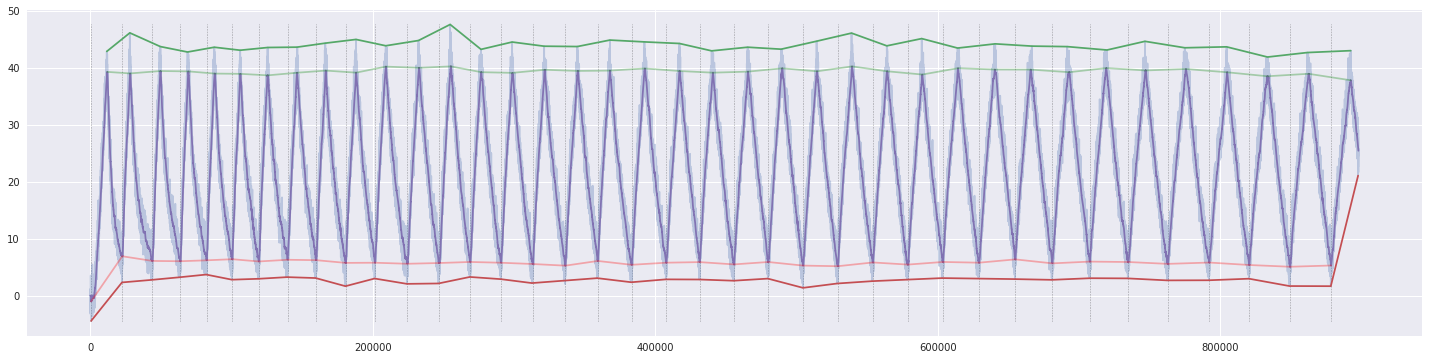

In [16]:
X_40 = label_cycles(X_40, minima, maxima, abs_min=abs_min, abs_max=abs_max)
plt.plot(X_40.f_ra); plt.plot(X_40.f_ra.iloc[minima], color='r', alpha=0.3); plt.plot(X_40.f_ra.iloc[maxima], color='g', alpha=0.3)

In [17]:
minima, maxima = get_extrema(X_100, ra=True) # n~=2000 is a safe order size for extrema: see next plot.
abs_min, abs_max = get_extrema(X_100, order=3000, ra=False)

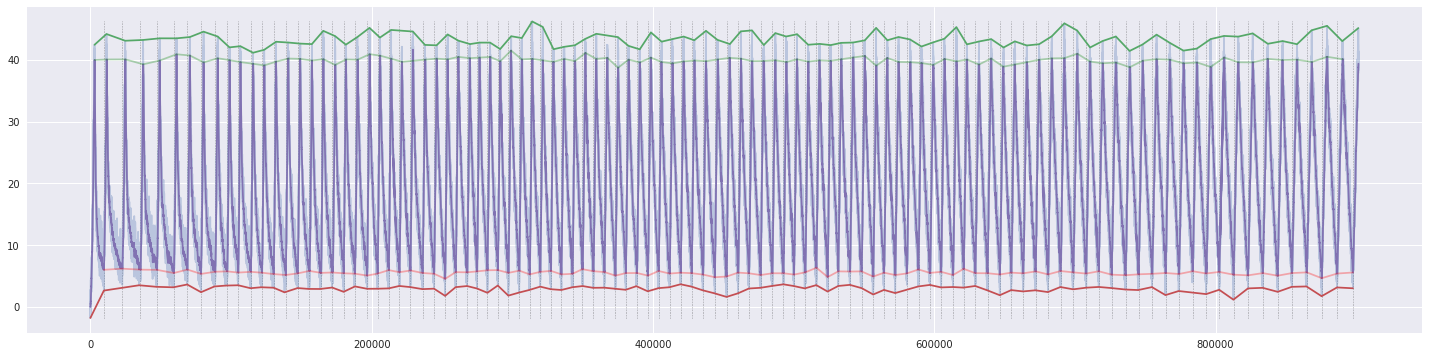

In [18]:
X_100 = label_cycles(X_100, minima, maxima, abs_min=abs_min, abs_max=abs_max)
plt.plot(X_100.f_ra); plt.plot(X_100.f_ra.iloc[minima], color='r', alpha=0.3); plt.plot(X_100.f_ra.iloc[maxima], color='g', alpha=0.3)

## Fix period and stationarity.
Mean, variance, and autocorrelation of each cycle are not quite constant. We can't usefully determine correlation between variables until stationarity is maintained. We can eliminate stationarity by differencing data:
$$
Y_i = Z_i - Z_{i-1} \quad \forall i\in\big(0, \dots,T\big)
$$
or by fitting a trend and removing residuals:
$$
Y = a + bln\,X
$$
We'd also like to enforce constant period (and add our detrended period back in later) for robust regression:
$$
P_t = P_{t+1} \quad \forall t \in\big(0, (T-1)\big)
$$
First, adjust for seasonality.

### Fix `36`-cycle periods.
We analyze variance with index of dispersion (normalized to mean):
$$
D = \frac{\sigma^2}{\mu}
$$

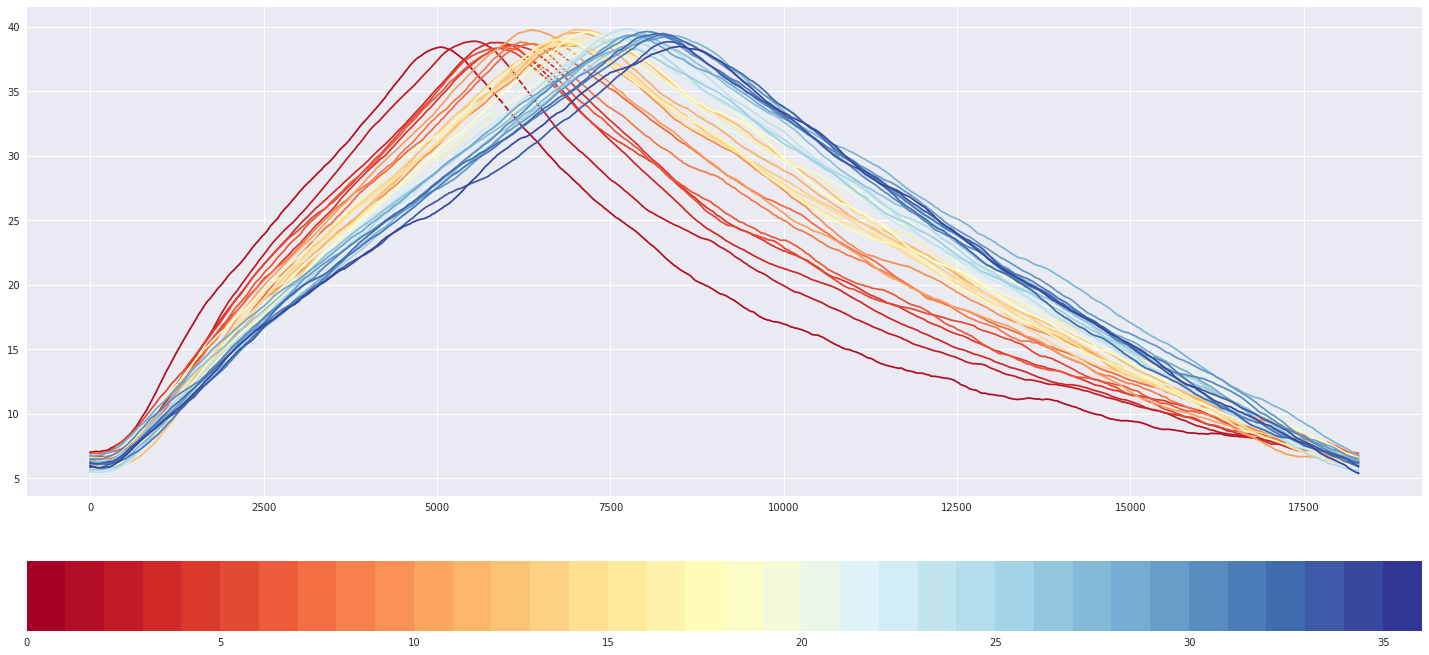

In [151]:
X_40S, c_to_p40 = squash_periods(X_40)

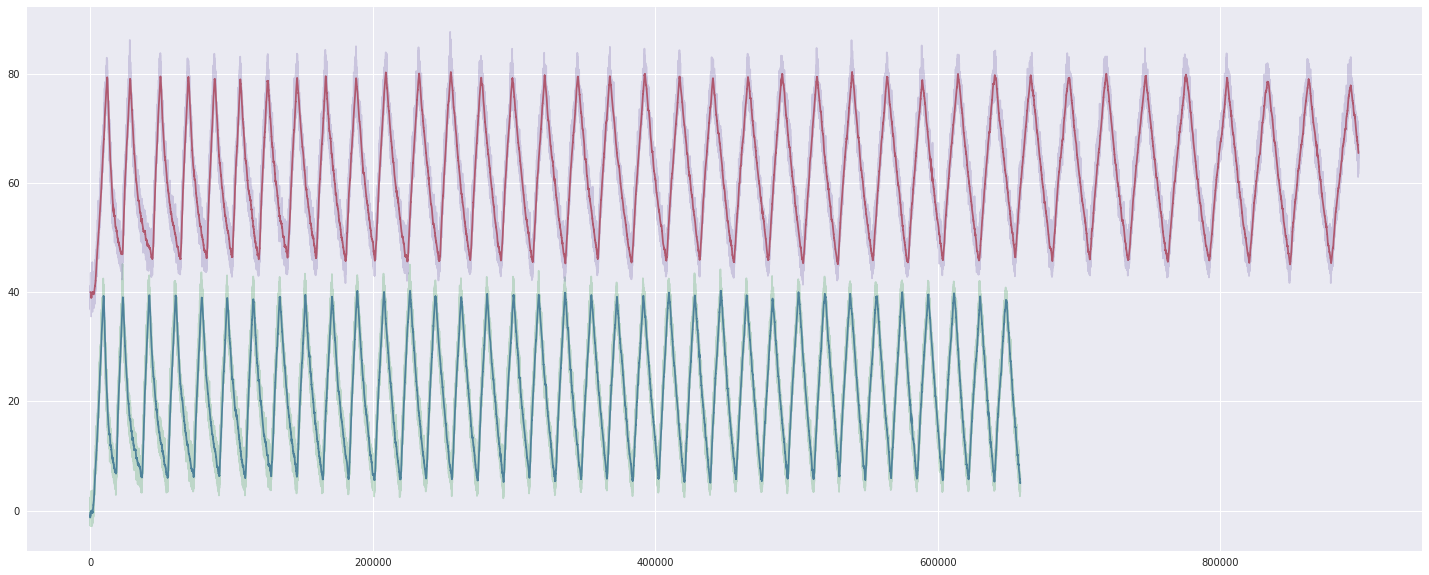

In [53]:
plt.plot(X_40S.f_ra); plt.plot(X_40S.f, alpha=0.3)
plt.plot(X_40.f_ra+40); plt.plot(X_40.f+40, alpha=0.3)

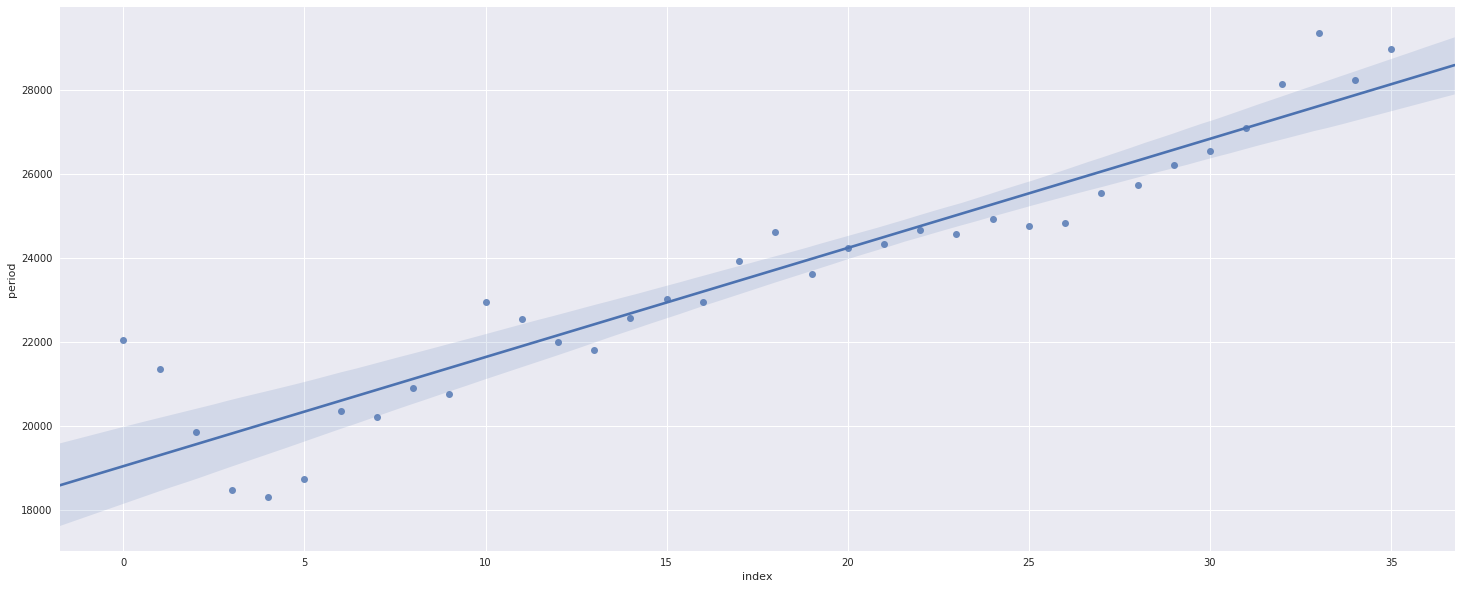

In [110]:
temp = pd.DataFrame(c_to_p40, index=[0]).transpose().reset_index(); temp.columns = ['index', 'period']
sns.regplot('index', 'period', temp, fit_reg=True)

In [21]:
stats(pd.Series(list(c_to_p40.values())))

SUMMARY

index of dispersion	347.846432
--------------------------------------------------
count       36.000000
mean     23579.416667
std       2904.541148
min      18290.000000
25%      21685.750000
50%      23764.000000
75%      25065.000000
max      29356.000000
dtype: float64


### Fix `103`-cycle periods.
We analyze variance with index of dispersion (normalized to mean):
$$
D = \frac{\sigma^2}{\mu}
$$

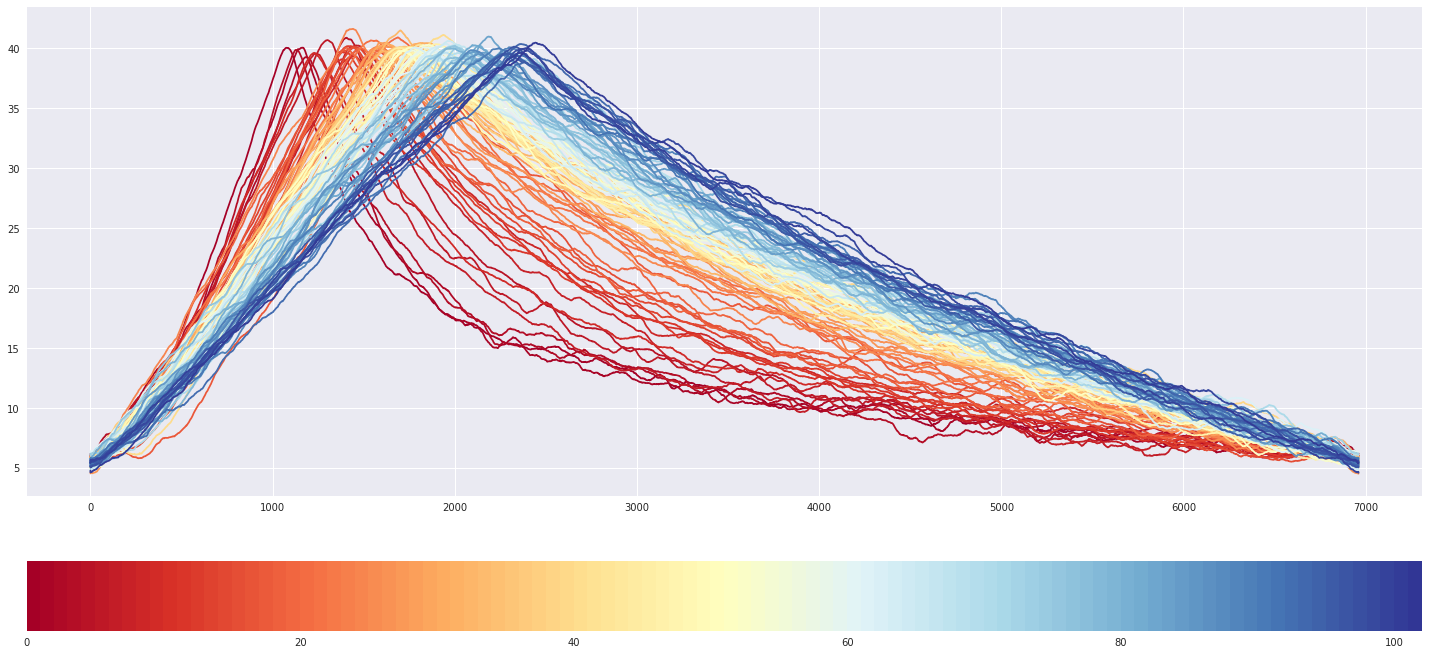

In [22]:
X_100S, c_to_p100 = squash_periods(X_100)

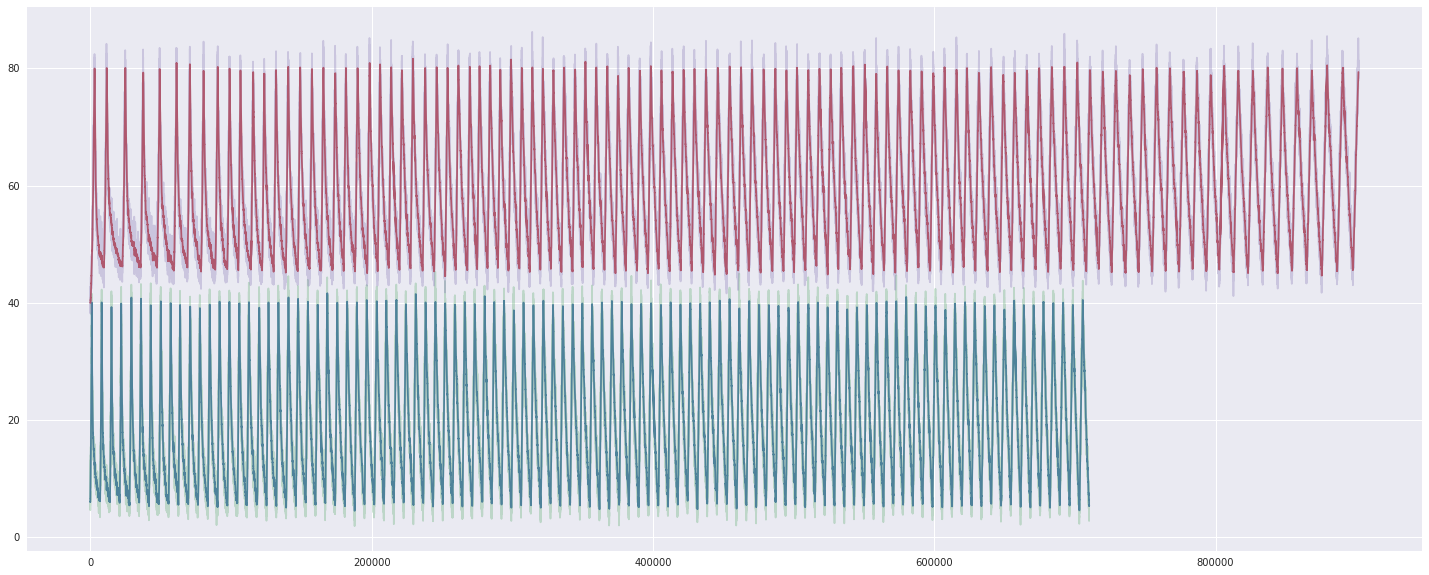

In [30]:
plt.plot(X_100S.f_ra); plt.plot(X_100S.f, alpha=0.3)
plt.plot(X_100.f_ra+40); plt.plot(X_100.f+40, alpha=0.3)

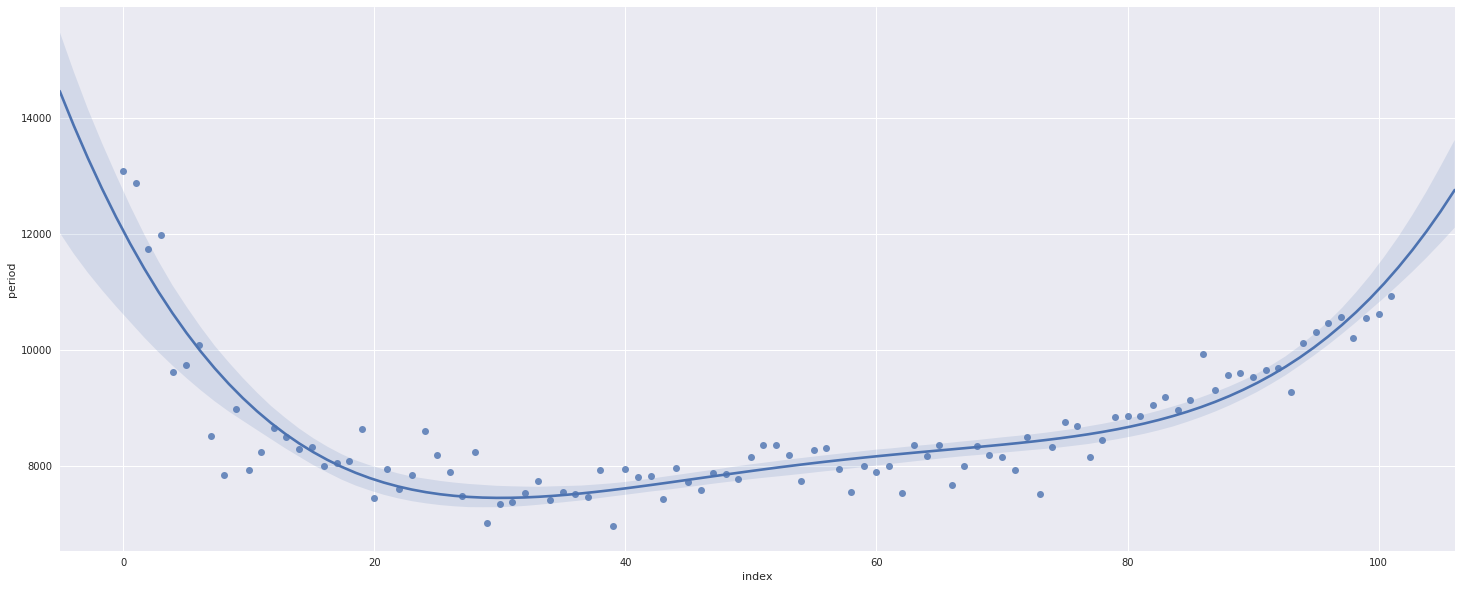

In [114]:
temp = pd.DataFrame(c_to_p100, index=[0]).transpose().reset_index(); temp.columns = ['index', 'period']
sns.regplot('index', 'period', temp, fit_reg=True, order=4)

In [24]:
stats(pd.Series(list(c_to_p100.values())))

SUMMARY

index of dispersion	162.000749
--------------------------------------------------
count      102.000000
mean      8595.049020
std       1185.829061
min       6962.000000
25%       7844.750000
50%       8236.000000
75%       9024.750000
max      13097.000000
dtype: float64


## Detrend data
by differencing:
$$
\Delta X_t = X_t - X_{t-1}
$$

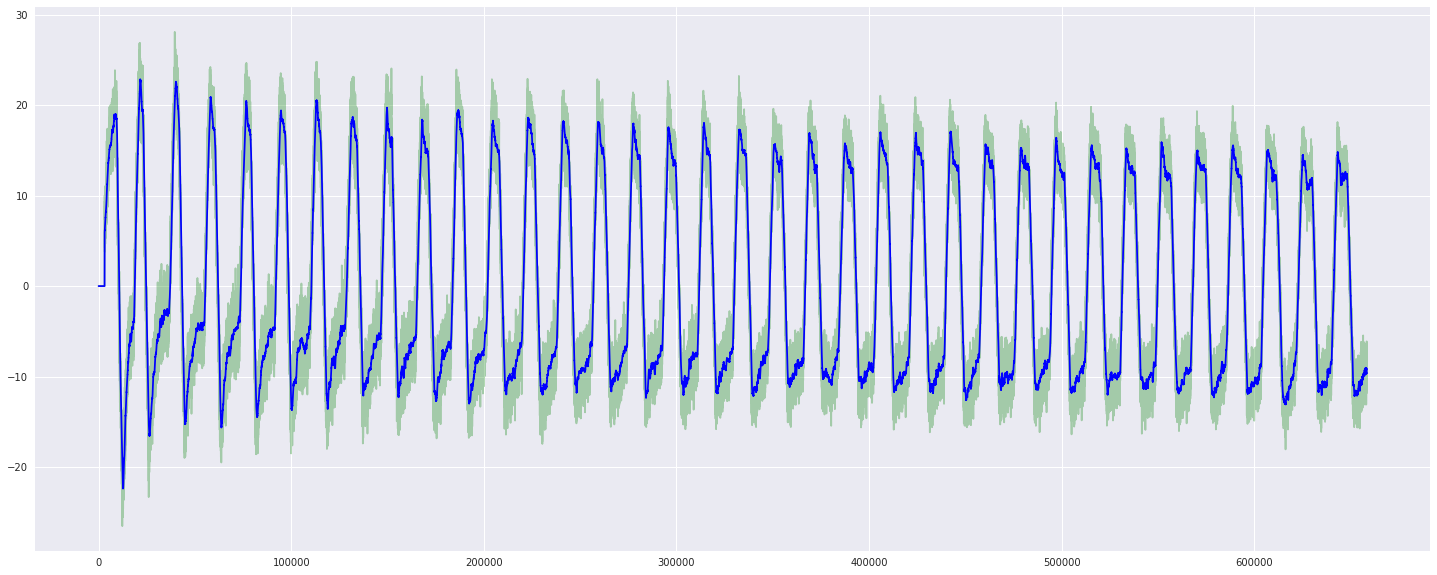

In [64]:
diffs = difference(X_40S)
plt.plot(diffs.f, alpha=0.3, color='g')
plt.plot(diffs.f_ra, color='b')

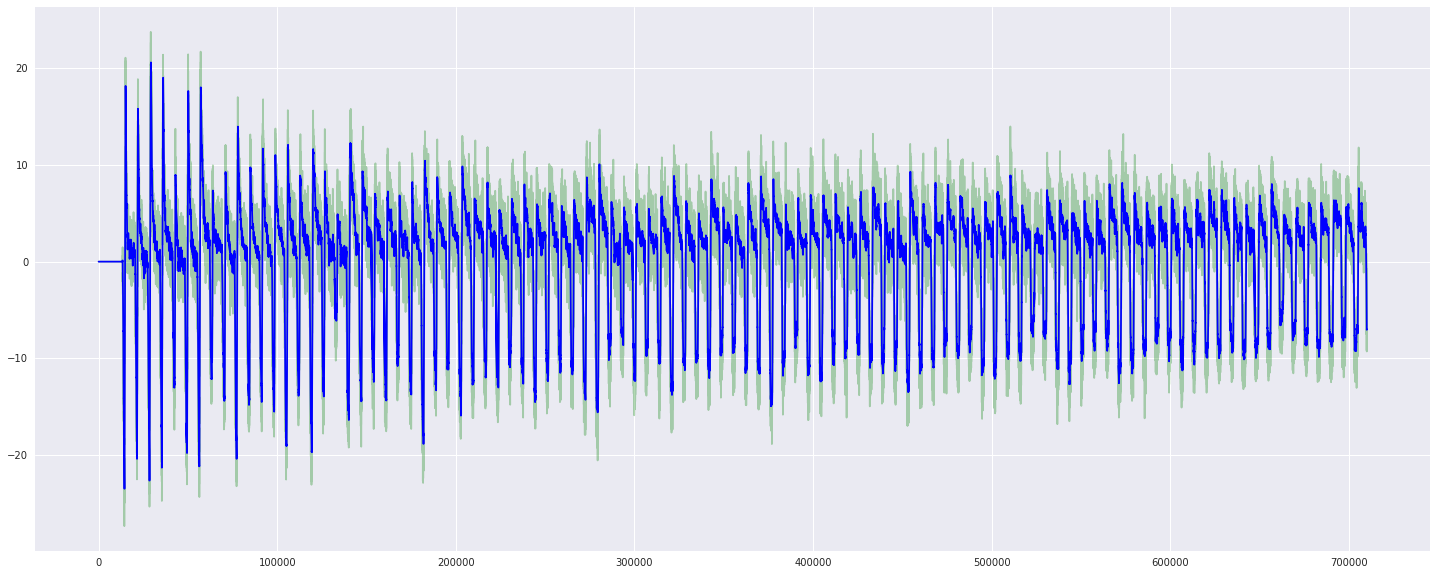

In [60]:
diffs = difference(X_100S)
plt.plot(diffs.f, alpha=0.3, color='g')
plt.plot(diffs.f_ra, color='b')

and by regression:

## Force stats over time.
Is force variance still accumulating (heteroscedatic) with conductive paste?

## Cyclic temperature
and correlation with force.

## Muscle linearity
(viability as an actuator)